# FCA DAB Image Analysis

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Preprocessing
To begin, we read in the images from the local folder and save them in the list 'images'

We will pick the first image and display it

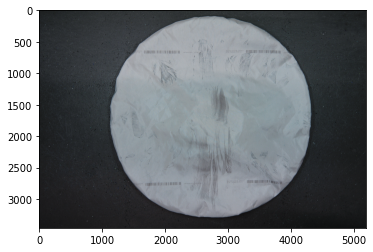

In [2]:
images_path = r"C:\Temp\JarekDAB\Cushion black marks analysis"
image_names = os.listdir(images_path)
image_files = [os.path.join(images_path, x) for x in image_names]
images = [cv2.imread(x, 1) for x in image_files]
df_top = pd.DataFrame(data={'name':image_names, 'image':images, 'placement':'top'})
df_bot = pd.DataFrame(data={'name':image_names, 'image':images, 'placement':'bottom'})
plt.imshow(images[0])

#### Cropping
Next, we crop the portion we are interested in and save them into the list 'images_c'

Again, displaying the first cropped image

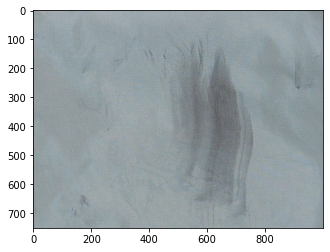

In [3]:
# Setting top and bottom coordinates (x, y, width, height)
df_top['coords'] = [(2250, 1100, 1000, 750)]*len(df_top)
df_bot['coords'] = [(2250, 2000, 1000, 1000)]*len(df_bot)

# Combine into one dataframe table
df = pd.concat([df_top, df_bot])
df = df.reset_index()

# Loop through each row of the table and crop image based on coords
images_c = []
for i, row in df.iterrows():
    image = row['image']
    x, y, width, height = row['coords']
    image_c = image[y:y+height, x:x+width]
    images_c.append(image_c)

plt.imshow(images_c[0])

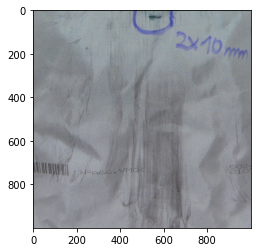

In [4]:
plt.imshow(images_c[-1])

#### Grayscale
After cropping, we convert the images to grayscale

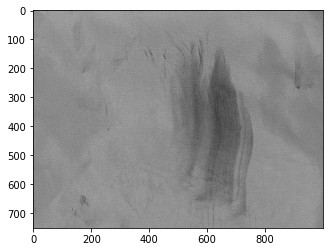

In [5]:
images_c_g = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images_c]
df['images_c_g'] = images_c_g
plt.imshow(images_c_g[0], cmap="gray")

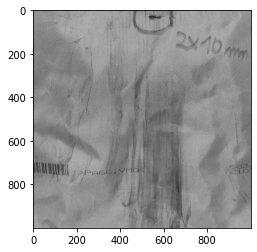

In [6]:
plt.imshow(images_c_g[-1], cmap="gray")

#### Thresholding
Now we take any pixel values over 127 and make them 0, any below we make 255. This makes the image only black and white with no gray values.

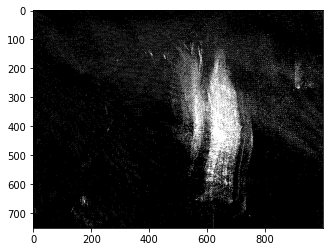

In [7]:
# images_threshold = [cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1] for image in images_gray]
# images_threshold = [cv2.bitwise_not(image) for image in images_threshold]
images_c_g_t = [cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)[1] for image in images_c_g]
plt.imshow(images_c_g_t[0], cmap="gray")

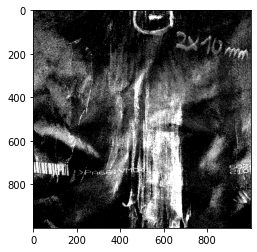

In [8]:
plt.imshow(images_c_g_t[-1], cmap="gray")

#### Morphology
This basically reduces noise in the image by combining like pixels and then undoing it

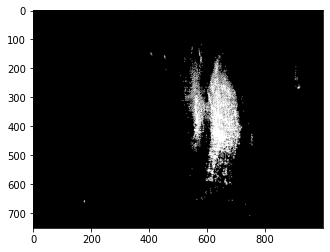

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
images_c_g_t_m = [cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel) for image in images_c_g_t]
plt.imshow(images_c_g_t_m[0], cmap="gray")

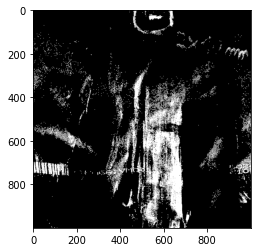

In [10]:
plt.imshow(images_c_g_t_m[-1], cmap="gray")

### Contours

In [11]:
def get_max_contours(contours_list):
    max_contours = []
    for i, contours in enumerate(contours_list):
        if len(contours) == 0:
            max_contours.append(np.nan)
        else:
            max_contours.append(max(contours, key=lambda x: cv2.contourArea(x)))
    return max_contours

In [12]:
# Prepare for contour drawing
# Gets contours for each image
contours_list = [cv2.findContours(image=image, 
                                  mode=cv2.RETR_TREE, 
                                  method=cv2.CHAIN_APPROX_SIMPLE)[0] for image in images_c_g_t_m]

# Gets image copies for drawing
df['images_box'] = [image.copy() for image in images_c]
df['images_fit'] = [image.copy() for image in images_c]

# Gets the biggest contours by area
df['max_contour'] = get_max_contours(contours_list)

# Drop any images with no detectable marks
df = df.dropna()
df.fillna(0, inplace=True)

#### Contours Boxes
Now we search for the biggest contours (the marks left by the flap) and draw a rectangle around them

In [13]:
def draw_box(contour, image):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image,(x,y), (x+w,y+h), (0,0,255), 5)
    return image    

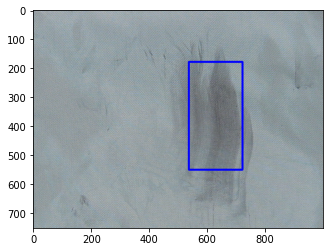

In [14]:
# Draws the boxes around the contours
images_boxed = [draw_box(contour, image) for contour, image \
                in zip(df['max_contour'].tolist(), df['images_box'].tolist())]
df['image_box'] = images_boxed
plt.imshow(images_boxed[0])

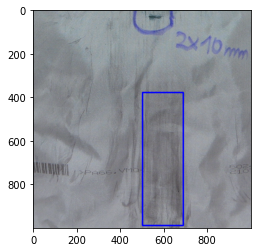

In [15]:
plt.imshow(images_boxed[-1])

#### Contours Fit
This alternative draws the contours instead of the box

In [16]:
def draw_fit(contour, image):
    cv2.drawContours(image=image, contours=contour, contourIdx=-1, color=(0, 255, 0), thickness=2)
    return image

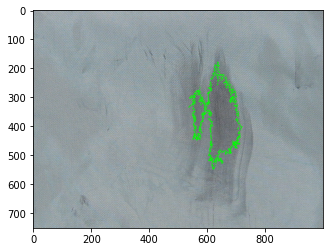

In [17]:
images_fit = [draw_fit(contour, image) for contour, image \
              in zip(df['max_contour'].tolist(), df['images_fit'].tolist())]
plt.imshow(images_fit[0])

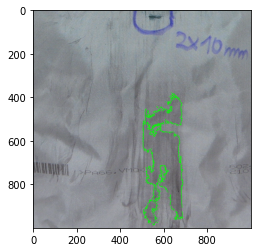

In [18]:
plt.imshow(images_fit[-1])

### Area and Intensity of Contours
Now we measure the area and intensity of all the contours and create a histogram. Looking through the results, any area above 200000 is most likely not real data (there was one image in portrait rather than landscape with an area of 400000). So we narrow the results to anything between 0 and 200000, and 0 and 20000.

In [30]:
def get_intensity(contour, image):
    x, y, w, h = cv2.boundingRect(contour)
    image_small = image[y:y+h, x:x+w]
    return np.mean(image_small)

<AxesSubplot:title={'center':'Smudge Area'}, xlabel='area_norm', ylabel='Count'>

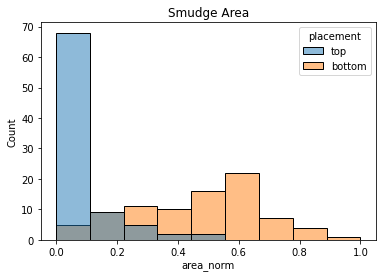

In [31]:
# Calculate areas
areas = []
for contour in df['max_contour'].tolist():
    try:
        areas.append(cv2.contourArea(contour))
    except:
        areas.append(np.nan)
df['area'] = areas

# Calculate intensities
df['intensity'] = [get_intensity(c, im) for c, im in \
                   zip(df['max_contour'].tolist(), df['images_c_g'].tolist())]
# df['intensity'] = [np.mean(x) for x in df['images_c_g']]

# Get rid of outliers
df = df[df['area'].between(0, 200000)]
df['area_norm'] = df['area'] / df['area'].max()
df['intensity_norm'] = 1 - df['intensity'] / df['intensity'].max()
plt.title('Smudge Area')
sns.histplot(x='area_norm', hue='placement', data=df)

<AxesSubplot:title={'center':'Smudge Area - Top'}, xlabel='area_norm', ylabel='Count'>

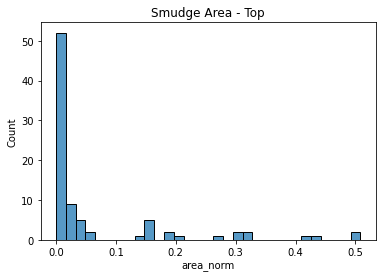

In [21]:
df_top = df[df['placement'] == 'top']
plt.title('Smudge Area - Top')
sns.histplot(x='area_norm', data=df_top)

<AxesSubplot:title={'center':'Smudge Area - Bottom'}, xlabel='area_norm', ylabel='Count'>

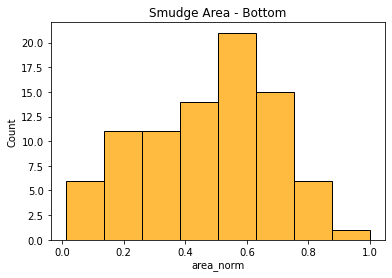

In [22]:
df_bot = df[df['placement'] == 'bottom']
plt.title('Smudge Area - Bottom')
sns.histplot(x='area_norm', data=df_bot, color='orange')

<AxesSubplot:title={'center':'Intensity Histogram'}, xlabel='intensity_norm', ylabel='Count'>

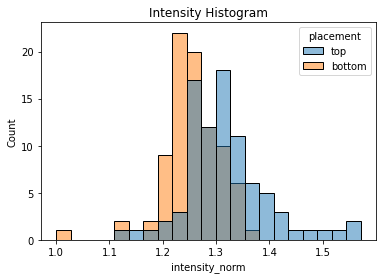

In [23]:
plt.title('Intensity Histogram')
sns.histplot(x='intensity_norm', hue='placement', data=df)

<AxesSubplot:title={'center':'Intensity Scatterplot'}, xlabel='placement', ylabel='intensity_norm'>

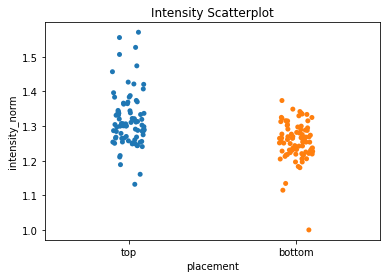

In [24]:
plt.title('Intensity Scatterplot')
sns.stripplot(x='placement', y='intensity_norm', data=df)

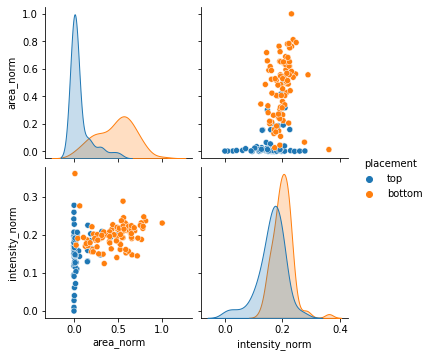

In [33]:
df_pairplot = df[['placement', 'area_norm', 'intensity_norm']]
# plt.title('Intensity vs Area')
sns.pairplot(df_pairplot, hue='placement')

## Output Data
This section saves the data to a csv file, and prints all the pictures with the values written on them. One section saves the images with the raw area and intensity, while the other saves the images with the normalized area and intensity.

In [26]:
df_final = df[['name', 'placement', 'area', 'intensity', 'area_norm', 'intensity_norm']]
df_final.to_csv('Output.csv')

In [27]:
output_folder = r"C:\Temp\JarekDAB\processed"
os.makedirs(output_folder, exist_ok=True)
for i, row in df.iterrows():
    image = row['image_box']
    area = row['area']
    intensity = row['intensity']
    image_copy = image.copy()
    cv2.putText(img=image_copy, text='Area: {0:5.2f}'.format(area), 
                org=(50, 100), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=2, color=(0, 255, 0),thickness=3)
    cv2.putText(img=image_copy, text='Intensity: {0:5.2f}'.format(intensity), 
                org=(50, 175), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=2, color=(0, 255, 0),thickness=3)
    save_path = os.path.join(output_folder, '{0}_{1}'.format(row['placement'], row['name']))
    cv2.imwrite(save_path, image_copy)

In [32]:
output_folder = r"C:\Temp\JarekDAB\processed_norm"
os.makedirs(output_folder, exist_ok=True)
for i, row in df.iterrows():
    image = row['image_box']
    area = row['area_norm']
    intensity = row['intensity_norm']
    image_copy = image.copy()
    cv2.putText(img=image_copy, text='Area: {0:5.2f}'.format(area), 
                org=(50, 100), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=2, color=(0, 255, 0),thickness=3)
    cv2.putText(img=image_copy, text='Intensity: {0:5.2f}'.format(intensity), 
                org=(50, 175), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=2, color=(0, 255, 0),thickness=3)
    save_path = os.path.join(output_folder, '{0}_{1}'.format(row['placement'], row['name']))
    cv2.imwrite(save_path, image_copy)

In [34]:
!jupyter nbconvert Untitled.ipynb --to html

[NbConvertApp] Converting notebook Untitled.ipynb to html
[NbConvertApp] Writing 2266721 bytes to Untitled.html
